In [390]:
import os
import glob
import numpy as np
import cv2
import shutil
import rawpy
import imageio
import tempfile
import matplotlib.pyplot as plt
%matplotlib inline

In [394]:
def apply_white_balance_raw(bayer_img, s=0.05):
    # Calculate the s-th percentile for each color channel
    p_b = np.percentile(bayer_img[::2, ::2], s)
    p_g1 = np.percentile(bayer_img[1::2, ::2], s)
    p_g2 = np.percentile(bayer_img[::2, 1::2], s)
    p_r = np.percentile(bayer_img[1::2, 1::2], s)

    # Calculate the top s-th percentile for each color channel
    p_b_top = np.percentile(bayer_img[::2, ::2], 100 - s)
    p_g1_top = np.percentile(bayer_img[1::2, ::2], 100 - s)
    p_g2_top = np.percentile(bayer_img[::2, 1::2], 100 - s)
    p_r_top = np.percentile(bayer_img[1::2, 1::2], 100 - s)

    # Apply white balance by scaling the color channels
    bayer_img[::2, ::2] = (bayer_img[::2, ::2] - p_b) / (p_b_top - p_b)
    bayer_img[1::2, ::2] = (bayer_img[1::2, ::2] - p_g1) / (p_g1_top - p_g1)
    bayer_img[::2, 1::2] = (bayer_img[::2, 1::2] - p_g2) / (p_g2_top - p_g2)
    bayer_img[1::2, 1::2] = (bayer_img[1::2, 1::2] - p_r) / (p_r_top - p_r)

    return bayer_img

    
def process_image(raw_data):
    if raw_data.shape[0] <= 8:
        raw_data = np.transpose(raw_data, (1, 2, 0))

    # Extract the Bayer pattern channels from the raw data
    b_raw, g1_raw, g2_raw, r_raw = raw_data[..., 0], raw_data[..., 1], raw_data[..., 2], raw_data[..., 3]

    h, w = g1_raw.shape

    # Create an empty Bayer pattern image that will hold the modified color channels
    bayer_img = np.zeros((h * 2, w * 2), dtype=np.float32)
    
    # Assign the extracted channels to their respective Bayer pattern locations
    bayer_img[1::2, 1::2] = r_raw
    bayer_img[::2, 1::2] = g2_raw
    bayer_img[1::2, ::2] = g1_raw
    bayer_img[::2, ::2] = b_raw

    # Apply white balance on the raw Bayer pattern image
    white_balanced_bayer_img = apply_white_balance_raw(bayer_img)

    # Convert the Bayer pattern image to a 3-channel RGB image
    rgb_image = cv2.cvtColor((65535 * white_balanced_bayer_img).astype(np.uint16), cv2.COLOR_BAYER_BG2BGR)

    # Normalize the RGB image to [0, 1] range
    scaled_image = rgb_image / 65535.0

    # Scale the white balanced image to [0, 255] range and convert to an 8-bit unsigned integer
    srgb_image = (scaled_image * 255).astype(np.uint8)

    return srgb_image

In [395]:
def process_and_save_npz(npz_file, output_path):
    data = np.load(npz_file)
    keys = ['sht', 'mid', 'lng', 'hdr']

    for key in keys:
        if data[key].shape[0] == 4:
            raw_data = data[key][:4]
        else:
            raw_data = data[key][4:]
            
        srgb_image = process_image(raw_data)
        output_file = os.path.join(output_path, f"{os.path.basename(npz_file).replace('.npz', '')}_{key}.png")
        imageio.imwrite(output_file, np.clip(srgb_image, 0, 255).astype(np.uint8))

In [ ]:
root_dir = 'data/NPZ_data'
output_dir = 'data/PNG_data'

# Empty the output_dir before running the code
shutil.rmtree(output_dir)
os.makedirs(output_dir)

total_processed = 0

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.npz'):
            npz_file_path = os.path.join(subdir, file)
            output_path = os.path.join(output_dir, subdir)
            os.makedirs(output_path, exist_ok=True)
            print(f"processing {npz_file_path}")
            try:
                process_and_save_npz(npz_file_path, output_path)
                print(f"       =====processed {npz_file_path} successfully")
                total_processed += 1
            except Exception as e:
                print(f"couldn't process {npz_file_path}, skipping")
                raise e

print("total processed =" + total_processed)


processing data/NPZ_data/training_npz/dynamic/2022-0719-1909-1091.npz
       =====processed data/NPZ_data/training_npz/dynamic/2022-0719-1909-1091.npz successfully
processing data/NPZ_data/training_npz/dynamic/2022-0719-2154-1900.npz
       =====processed data/NPZ_data/training_npz/dynamic/2022-0719-2154-1900.npz successfully
processing data/NPZ_data/training_npz/dynamic/2022-0701-1727-4506.npz
       =====processed data/NPZ_data/training_npz/dynamic/2022-0701-1727-4506.npz successfully
processing data/NPZ_data/training_npz/dynamic/2022-0727-1543-2279.npz
       =====processed data/NPZ_data/training_npz/dynamic/2022-0727-1543-2279.npz successfully
processing data/NPZ_data/training_npz/dynamic/2022-0727-1522-1743.npz
       =====processed data/NPZ_data/training_npz/dynamic/2022-0727-1522-1743.npz successfully
processing data/NPZ_data/training_npz/dynamic/2022-0706-2013-4216.npz
       =====processed data/NPZ_data/training_npz/dynamic/2022-0706-2013-4216.npz successfully
processing data/

In [ ]:
repr_data = "data/NPZ_data/training_npz/dynamic/2022-0621-1804-5437.npz"
not_repr_data = "data/NPZ_data/training_npz/dynamic/2022-0719-1909-1091.npz"
np_data = np.load(repr_data)

In [301]:
np_data_B = np.load(not_repr_data)

sht_B = np_data_B['sht']
mid_B = np_data_B['mid']
lng_B = np_data_B['lng']
hdr_B = np_data_B['hdr']

In [326]:
sht.shape

(8, 1728, 2304)

In [327]:
sht_B.shape

(8, 1528, 2040)

In [302]:
sht = np_data['sht']
mid = np_data['mid']
lng = np_data['lng']
hdr = np_data['hdr']

In [324]:
def get_rgb(raw):
    if raw.shape[0] <= 8:
        raw = np.transpose(raw, (1, 2, 0))

    print(f"processing shape {raw.shape}")

    scaled_image_data = (raw * 65535).astype(np.uint16)
    
    temp_file = tempfile.NamedTemporaryFile(suffix=".dng", delete=False)
    temp_file.write(scaled_image_data.tobytes())
    temp_file.close()

    print("saved in " + temp_file.name)
    
    raw = rawpy.imread(temp_file.name)
    
    
    rgb = raw.postprocess(use_auto_wb=True)
    
    return rgb

In [325]:
i_hdr = get_rgb(hdr)
i_sht = get_rgb(sht[4:])
i_mid = get_rgb(mid[4:])
i_lng = get_rgb(lng[4:])

processing shape (1728, 2304, 4)
saved in /tmp/tmp9flk46h3.dng
processing shape (1728, 2304, 4)
saved in /tmp/tmpe0qw2c3d.dng
processing shape (1728, 2304, 4)
saved in /tmp/tmpvxzormrq.dng
processing shape (1728, 2304, 4)
saved in /tmp/tmpishliy54.dng


In [299]:
hdr[:4][0]

array([[1.13526832e-04, 1.15340357e-04, 9.97440220e-05, ...,
        1.82440868e-04, 1.83529002e-04, 1.94410153e-04],
       [1.16428484e-04, 1.17879295e-04, 1.05184605e-04, ...,
        1.91508530e-04, 1.76637608e-04, 1.98399925e-04],
       [1.06272724e-04, 1.26946936e-04, 1.17516589e-04, ...,
        1.86067948e-04, 1.80627365e-04, 1.84617122e-04],
       ...,
       [2.73443068e-03, 2.66865818e-03, 2.70515729e-03, ...,
        1.53714610e-03, 1.53678329e-03, 1.50341440e-03],
       [2.67415895e-03, 2.66145848e-03, 2.63295940e-03, ...,
        1.54079282e-03, 1.54004774e-03, 1.52263779e-03],
       [2.69943050e-03, 2.68966391e-03, 2.64761721e-03, ...,
        1.48382831e-03, 1.52143683e-03, 1.52191241e-03]])

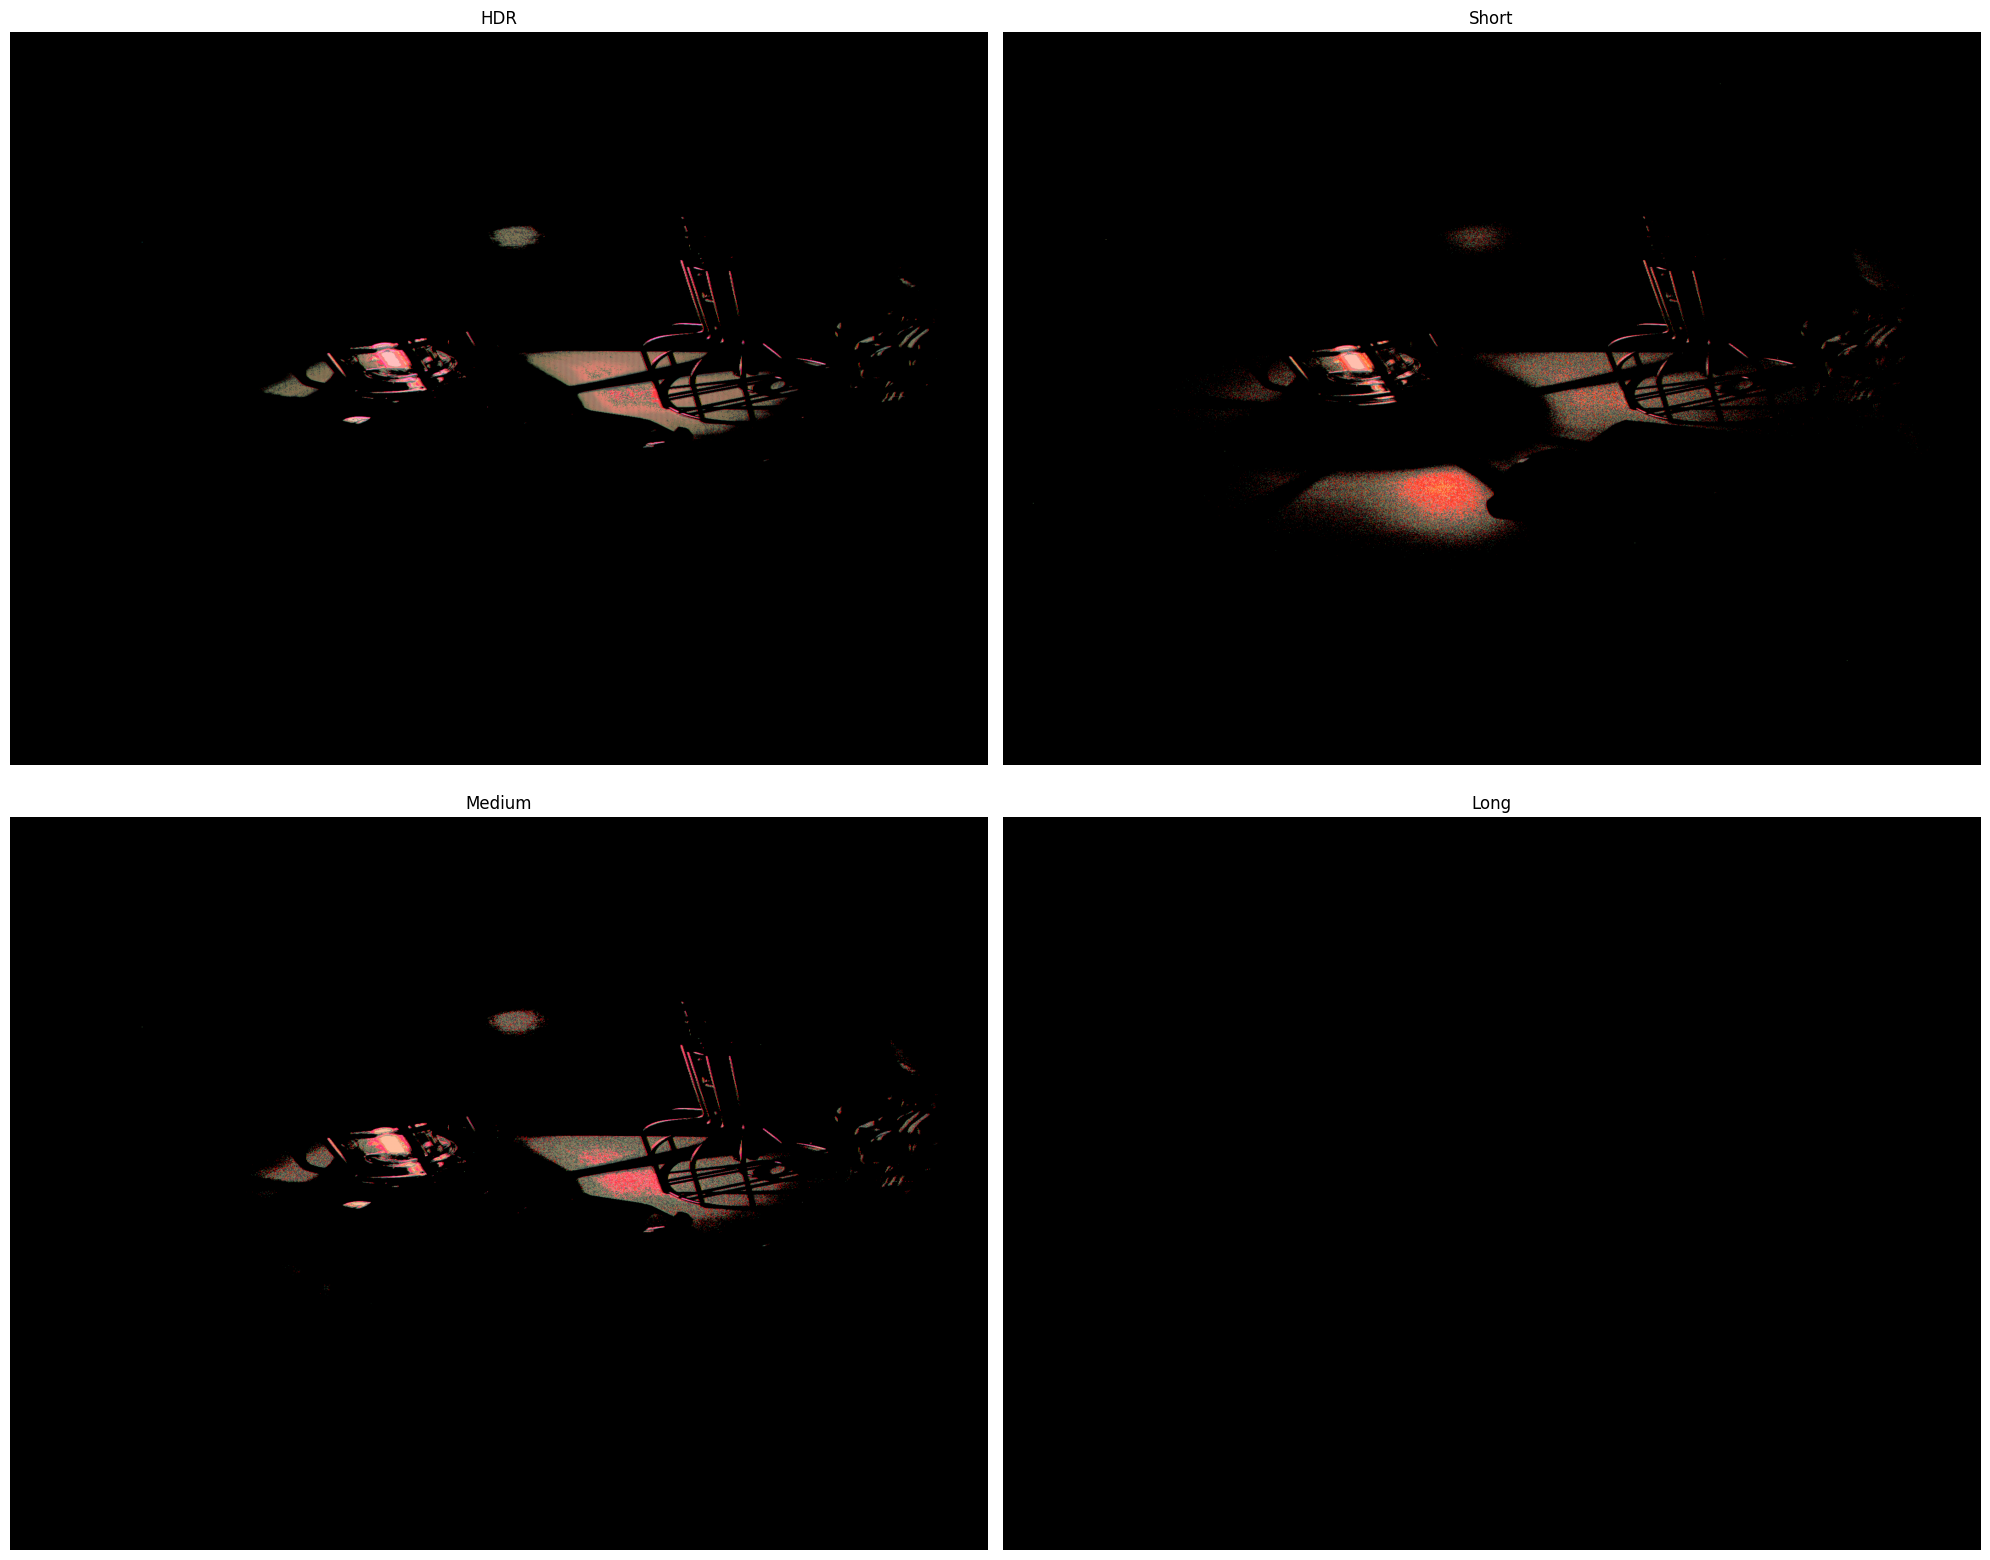

In [300]:
# Create a figure and subplots with a 2x2 grid
fig, axes = plt.subplots(2, 2)

# Set the figure size to make the images appear bigger
fig.set_figwidth(20)
fig.set_figheight(16)

# Display each image in a subplot and add a caption
axes[0, 0].imshow(i_hdr)
axes[0, 0].set_title('HDR')

axes[0, 1].imshow(i_sht)
axes[0, 1].set_title('Short')

axes[1, 0].imshow(i_mid)
axes[1, 0].set_title('Medium')

axes[1, 1].imshow(i_lng)
axes[1, 1].set_title('Long')

# Hide the x and y axis ticks
for ax in axes.flatten():
    ax.axis('off')

# Adjust the spacing between subplots for better layout
plt.tight_layout()

# Show the plot
plt.show()